#### 1. Importing the libraries and loading the data

In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime, timedelta
from datetime import datetime
import sklearn
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from boruta import BorutaPy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from shap import summary_plot
import joblib
import pickle
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
pd.set_option('display.float_format', '{:.2f}'.format)

C:\Users\ivine.mwenesi\Anaconda3\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\ivine.mwenesi\Anaconda3\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, m

In [2]:
kenya = pd.read_csv('Kenya_National.csv')
kenya.head(2)

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,time,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label
0,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_AGR,Economic activity (Broad sector): Agriculture,NaN,NaN,2021,7516.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
kenya.shape

(11869, 22)

In [4]:
population = pd.read_csv('Population_data.csv')
population.head(2)

,ccode,name,num_code,year,age,sex,population
0,GHA,Ghana,288,2015,15,female,184146.56
1,GHA,Ghana,288,2015,15,male,193092.96


#Understanding the data sets as per the Data Dictionary

1. ref_area - Geographical info: this case, the countries, RWA, KEN, GHA
2. ref_area.label - Country Full name: Rwanda, Kenya, Ghana
3. source - The Source of the Data
4. indicator - The indicator being measured or observed
5. indicator.label - The label or Name of indicator: Employment by sex and economic activity, Unemployment rate by sex and age,
   Inactivity rate by sex and age, Employment by sex, age and education, Employment by sex, age and economic activity, 
   Unemployment by sex, age and education, Inactivity rate by sex, age and education.
   #Employment, unemployment, Inactivity. #Sex, Economic activity, Age, Education

6. sex - categorizes the data based on gender.
7. sex.label - broad label based on gender: Sex Total, Sex Male, Sex Female
8. classif1 - a classification category that may help further categorize or group the data in the dataset
9. classif1.label - a label or name for the first classification category, classif1. Has the Economic activities per ISIC 
   definitions. Also has Age brackets; 15+, 15-24.
    
10. classif2 - another classification category that may offer additional grouping or categorization
11. classif2.label - a label or name for the second classification category, classif2. Has the Economic activities per ISIC 
    definitions. Also has Education levels; No schooling, pre-primarym primary, lower and upper secondary, first and second 
    stages tertiary education.
    
12. time - the year when the observation was made
13. obs_value - the numerical information to be analysed and interpreted. It holds the actual observed value or data point 
    for the corresponding combination of reference area, indicator, sex, classif1, classif2 and time.

14. obs_status - nan, 'A', 'R', 'U', 'B'
15. obs_status.label - nan, 'Adjusted', 'Real Value', 'Unreliable', 'Break in series'
16. note_classif - nan, C3:988
17. note_classif.label - Just one; Nonstandard education level 
18. note_indicator - nan, I11:264, T5:3662_I11:264
19. note_indicator.label - nan, 'Break in series: Methodology revised', 'Unemployment definition: Two criteria (not in 
    employment and seeking or currently available) | Break in series: Methodology revised'
        
20. note_source - nan, 'R1:3513'
21. note_source.label - nan, 'Repository: ILO-STATISTICS - Micro data processing

*Indicators*

1. Inactivity rate by sex and age -- ILO modelled estimates, Nov. 2022 (%):  
2. Unemployment rate by sex and age -- ILO modelled estimates, Nov. 2022 (%): 
3. Employment by sex and economic activity -- ILO modelled estimates, Nov. 2022 (thousands): 
4. Employment by sex, age and economic activity (thousands)
5. Unemployment by sex, age and education (thousands)
6. Employment by sex, age and education (thousands): 
7. Inactivity rate by sex, age and education (%): 

#### 2. Exploratory Data Analysis

###### a. Understanding Kenya's Population Dataset

In [5]:
kenya_population = population.query("name == 'Kenya' ")
kenya_population

,ccode,name,num_code,year,age,sex,population
1092,KEN,Kenya,404,2015,15,female,341486.56
1093,KEN,Kenya,404,2015,15,male,344435.68
1094,KEN,Kenya,404,2015,16,female,499980.48
1095,KEN,Kenya,404,2015,16,male,504210.88
1096,KEN,Kenya,404,2015,17,female,598556.48
...,...,...,...,...,...,...,...
2179,KEN,Kenya,404,2040,33,male,622171.68
2180,KEN,Kenya,404,2040,34,female,607626.08
2181,KEN,Kenya,404,2040,34,male,603944.32
2182,KEN,Kenya,404,2040,35,female,591243.36


In [6]:
#Univatiate analysis on the Population showing the distribution of the population

#Age distribution
kenya_population['age'].min(), kenya_population['age'].max()

(15, 35)

In [7]:
#Period range of the years
kenya_population['year'].min(), kenya_population['year'].max()

(2015, 2040)

In [8]:
#Checking the datatypes using .info to see how to visualize the different features

kenya_population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092 entries, 1092 to 2183
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ccode       1092 non-null   object 
 1   name        1092 non-null   object 
 2   num_code    1092 non-null   int64  
 3   year        1092 non-null   int64  
 4   age         1092 non-null   int64  
 5   sex         1092 non-null   object 
 6   population  1092 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 68.2+ KB


Text(0.5, 1.0, '2015-2040 Population of Kenya Youth')

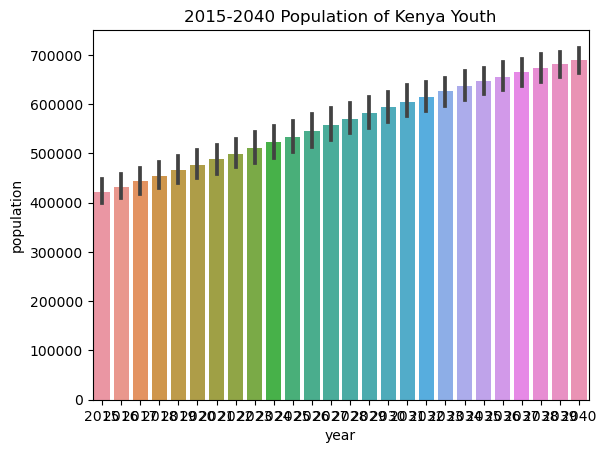

In [9]:
#Bivariate analysis of Year against Population

plot1 = sns.barplot(data=kenya_population, x="year", y="population").set_title('2015-2040 Population of Kenya Youth')
plot1

Text(0.5, 1.0, 'Age - Population Distribution')

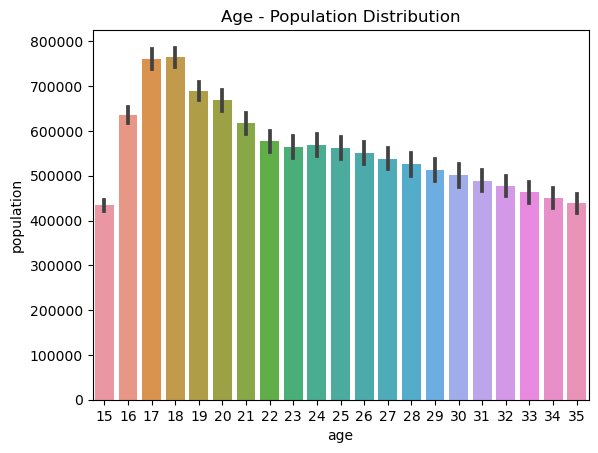

In [10]:
#Bivariate analysis of Age against Population

plot3 = sns.barplot(data=kenya_population, x="age", y="population").set_title('Age - Population Distribution')
plot3


Text(0.5, 1.0, 'Age-Population Distribution By Gender')

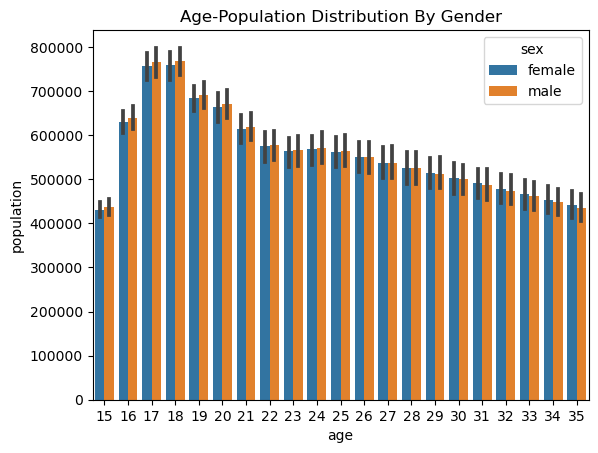

In [11]:
#Tri (or is it multi, remember to check) variate analysis of Age, Population and Sex

plot4 = sns.barplot(data=kenya_population, x="age", y="population", hue="sex").set_title('Age-Population Distribution By Gender')
plot4

#### b. Understanding the Second Kenya dataset given

In [12]:
#The other data set
kenya

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,time,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label
0,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_AGR,Economic activity (Broad sector): Agriculture,NaN,NaN,2021,7516.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_IND,Economic activity (Broad sector): Industry,NaN,NaN,2021,3578.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_SER,Economic activity (Broad sector): Services,NaN,NaN,2021,11659.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_M,Sex: Male,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,11502.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11864,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_2,Education (ISCED-97): 2. Lower secondary or se...,2005,96.69,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...
11865,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_3,Education (ISCED-97): 3. Upper secondary educa...,2005,84.38,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...
11866,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_4,Education (ISCED-97): 4. Post-secondary non-te...,2005,100.00,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...
11867,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_5,Education (ISCED-97): 5. First stage of tertia...,2005,27.50,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...


In [13]:
#Indicators
'''  'EMP_2EMP_SEX_ECO_NB' (Employment By sex and economic activity --ILO modelled estimates),
     'UNE_2EAP_SEX_AGE_RT'(Unemployment rate by sex and age -- ILO modelled estimates, Nov. 2022(%)),
     'EIP_2WAP_SEX_AGE_RT'(Inactivity rate by sex and age -- ILO modelled estimates, Nov. 2022(%)),
     'EMP_TEMP_SEX_AGE_EDU_NB'(Employment by sex, age and education (thousands)),
     'EMP_TEMP_SEX_AGE_ECO_NB'(Employment by sex, age and economic activity(thousands)),
     'UNE_TUNE_SEX_AGE_EDU_NB'(Unemployment by sex, age and education (thousands),
     'EIP_DWAP_SEX_AGE_EDU_RT' (Inactivity rate by sex, age and education level)
     '''

kenya['indicator'].nunique()

7

In [14]:
##What really is Classif1? (It's indicators mostly with Eco (ISIC economic activities) and Age (Age bands))

kenya['classif1'].unique()

array(['ECO_SECTOR_TOTAL', 'ECO_SECTOR_AGR', 'ECO_SECTOR_IND',
       'ECO_SECTOR_SER', 'ECO_AGGREGATE_TOTAL', 'ECO_AGGREGATE_AGR',
       'ECO_AGGREGATE_MAN', 'ECO_AGGREGATE_CON', 'ECO_AGGREGATE_MEL',
       'ECO_AGGREGATE_MKT', 'ECO_AGGREGATE_PUB', 'ECO_DETAILS_TOTAL',
       'ECO_DETAILS_A', 'ECO_DETAILS_B', 'ECO_DETAILS_C',
       'ECO_DETAILS_DE', 'ECO_DETAILS_F', 'ECO_DETAILS_G',
       'ECO_DETAILS_HJ', 'ECO_DETAILS_I', 'ECO_DETAILS_K',
       'ECO_DETAILS_LMN', 'ECO_DETAILS_O', 'ECO_DETAILS_P',
       'ECO_DETAILS_Q', 'ECO_DETAILS_RSTU', 'AGE_YTHADULT_YGE15',
       'AGE_YTHADULT_Y15-24', 'AGE_YTHADULT_YGE25', 'AGE_YTHADULT_Y15-64',
       'AGE_AGGREGATE_TOTAL', 'AGE_AGGREGATE_Y15-24',
       'AGE_AGGREGATE_Y25-54', 'AGE_AGGREGATE_Y55-64',
       'AGE_AGGREGATE_YGE65', 'AGE_10YRBANDS_TOTAL',
       'AGE_10YRBANDS_Y15-24', 'AGE_10YRBANDS_Y25-34',
       'AGE_10YRBANDS_Y35-44', 'AGE_10YRBANDS_Y45-54',
       'AGE_10YRBANDS_Y55-64', 'AGE_10YRBANDS_YGE65'], dtype=object)

In [15]:
#What really is Classif2? (It's indicators with mostly with Edu(education) and Eco(ISIC economic activities))

kenya['classif2'].unique()

array([nan, 'EDU_AGGREGATE_TOTAL', 'EDU_AGGREGATE_LTB',
       'EDU_AGGREGATE_BAS', 'EDU_AGGREGATE_INT', 'EDU_AGGREGATE_ADV',
       'EDU_AGGREGATE_X', 'EDU_ISCED11_TOTAL', 'EDU_ISCED11_X',
       'EDU_ISCED11_0', 'EDU_ISCED11_1', 'EDU_ISCED11_2', 'EDU_ISCED11_3',
       'EDU_ISCED11_4', 'EDU_ISCED11_6', 'EDU_ISCED11_7', 'EDU_ISCED11_8',
       'EDU_ISCED11_9', 'EDU_ISCED97_TOTAL', 'EDU_ISCED97_X',
       'EDU_ISCED97_0', 'EDU_ISCED97_1', 'EDU_ISCED97_2', 'EDU_ISCED97_3',
       'EDU_ISCED97_4', 'EDU_ISCED97_5', 'EDU_ISCED97_6',
       'EDU_ISCED97_UNK', 'ECO_SECTOR_TOTAL', 'ECO_SECTOR_AGR',
       'ECO_SECTOR_NAG', 'ECO_SECTOR_IND', 'ECO_SECTOR_SER',
       'ECO_SECTOR_X', 'ECO_AGGREGATE_TOTAL', 'ECO_AGGREGATE_AGR',
       'ECO_AGGREGATE_MAN', 'ECO_AGGREGATE_CON', 'ECO_AGGREGATE_MEL',
       'ECO_AGGREGATE_MKT', 'ECO_AGGREGATE_PUB', 'ECO_AGGREGATE_X',
       'ECO_ISIC4_TOTAL', 'ECO_ISIC4_A', 'ECO_ISIC4_B', 'ECO_ISIC4_C',
       'ECO_ISIC4_D', 'ECO_ISIC4_E', 'ECO_ISIC4_F', 'ECO_ISIC4_G

In [16]:
#What period the Data runs across

kenya['time'].min(), kenya['time'].max()

(2000, 2024)

#### c. Getting a final data set from the two Datasets

In [17]:
#Introducing 'Population' feature to the kenya DataFrame

#First Renaming 'time' to year in kenya DataFrame


kenya_renamed_col = kenya.rename(columns = {'time': 'year'})
kenya_renamed_col.head(2)

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label
0,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_AGR,Economic activity (Broad sector): Agriculture,NaN,NaN,2021,7516.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#Setting an identifier to the Kenya data
kenya_renamed_col['primary_key'] = kenya_renamed_col.index
kenya_renamed_col.shape


(11869, 23)

In [19]:
kenya_population

,ccode,name,num_code,year,age,sex,population
1092,KEN,Kenya,404,2015,15,female,341486.56
1093,KEN,Kenya,404,2015,15,male,344435.68
1094,KEN,Kenya,404,2015,16,female,499980.48
1095,KEN,Kenya,404,2015,16,male,504210.88
1096,KEN,Kenya,404,2015,17,female,598556.48
...,...,...,...,...,...,...,...
2179,KEN,Kenya,404,2040,33,male,622171.68
2180,KEN,Kenya,404,2040,34,female,607626.08
2181,KEN,Kenya,404,2040,34,male,603944.32
2182,KEN,Kenya,404,2040,35,female,591243.36


In [20]:
new_kenya_data = pd.merge(kenya_renamed_col, kenya_population[['year','age', 'population', 'name']], on=['year'], how ='left')
new_kenya_data

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label,primary_key,age,population,name
0,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15.00,394724.96,Kenya
1,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15.00,399484.54,Kenya
2,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16.00,577003.04,Kenya
3,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16.00,583956.29,Kenya
4,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EMP_2EMP_SEX_ECO_NB,Employment by sex and economic activity -- ILO...,SEX_T,Sex: Total,ECO_SECTOR_TOTAL,Economic activity (Broad sector): Total,NaN,NaN,2021,22755.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17.00,691420.00,Kenya
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263399,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_2,Education (ISCED-97): 2. Lower secondary or se...,2005,96.69,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,11864,NaN,NaN,NaN
263400,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_3,Education (ISCED-97): 3. Upper secondary educa...,2005,84.38,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,11865,NaN,NaN,NaN
263401,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_4,Education (ISCED-97): 4. Post-secondary non-te...,2005,100.00,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,11866,NaN,NaN,NaN
263402,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EIP_DWAP_SEX_AGE_EDU_RT,"Inactivity rate by sex, age and education (%)",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_5,Education (ISCED-97): 5. First stage of tertia...,2005,27.50,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,11867,NaN,NaN,NaN


In [21]:
new_kenya_data['dup'] = new_kenya_data.duplicated(subset=['primary_key'], keep='first')

In [22]:
new_kenya_data['dup'].value_counts()

dup
True     251535
False     11869
Name: count, dtype: int64

In [23]:
new_kenya_data = new_kenya_data[new_kenya_data['dup'] == False ]
new_kenya_data.shape

(11869, 27)

In [24]:
#Checker
new_kenya_data["year"].min(), new_kenya_data["year"].max(), new_kenya_data.shape

(2000, 2024, (11869, 27))

###### >>>> Feature Engineering for additional features

In [25]:
#Null value treatment on "classif2" and 'classif2.label' 
#Filling that with the mode

data = new_kenya_data.copy()

In [26]:
data.isna().sum()

ref_area                    0
ref_area.label              0
source                      0
source.label                0
indicator                   0
indicator.label             0
sex                         0
sex.label                   0
classif1                    0
classif1.label              0
classif2                 2166
classif2.label           2166
year                        0
obs_value                 591
obs_status               6053
obs_status.label         6053
note_classif            11449
note_classif.label      11449
note_indicator           7575
note_indicator.label     7575
note_source              2166
note_source.label        2166
primary_key                 0
age                      5734
population               5734
name                     5734
dup                         0
dtype: int64

##### >>>Null Value treatment
_Fill null value of classif2 and classif2.label with mode_

In [27]:
#Summary stats for 'obs_value' per 'indicator' and 'classif1'
data['classif2'].mode(), data['classif2.label'].mode()


(0    EDU_AGGREGATE_TOTAL
 Name: classif2, dtype: object,
 0    Education (Aggregate levels): Total
 Name: classif2.label, dtype: object)

In [28]:
data[['classif2', 'classif2.label']]= data[['classif2', 'classif2.label']].fillna(data[['classif2', 'classif2.label']].mode().iloc[0])
data.isna().sum()

ref_area                    0
ref_area.label              0
source                      0
source.label                0
indicator                   0
indicator.label             0
sex                         0
sex.label                   0
classif1                    0
classif1.label              0
classif2                    0
classif2.label              0
year                        0
obs_value                 591
obs_status               6053
obs_status.label         6053
note_classif            11449
note_classif.label      11449
note_indicator           7575
note_indicator.label     7575
note_source              2166
note_source.label        2166
primary_key                 0
age                      5734
population               5734
name                     5734
dup                         0
dtype: int64

_Filling null obs_value with values median values per indicator classif1_

In [29]:
#Group the data per 'classif1' type then Calculate the median 'obs_value'per group then fill the null values of 'obs_value' 
groups = data.groupby('indicator')

def impute_median(series):
    series = series.fillna(series.median())
    return series

data['obs_value'] = groups['obs_value'].transform(impute_median)

#Checking the summmary stats of 'obs_value' per indicator
data.groupby(['classif1', 'indicator'])['obs_value'].describe()

count     mean     std     min  \
classif1             indicator                                                 
AGE_10YRBANDS_TOTAL  EIP_DWAP_SEX_AGE_EDU_RT 194.00    30.54   12.43    5.28   
                     EMP_TEMP_SEX_AGE_ECO_NB  40.00  4403.22 4704.61   90.48   
                     EMP_TEMP_SEX_AGE_EDU_NB 195.00  2493.05 3758.93    5.67   
                     UNE_TUNE_SEX_AGE_EDU_NB 184.00   177.85  253.48    0.33   
AGE_10YRBANDS_Y15-24 EIP_DWAP_SEX_AGE_EDU_RT 185.00    54.98   14.95   19.19   
                     EMP_TEMP_SEX_AGE_ECO_NB  40.00   737.39  734.26   15.05   
                     EMP_TEMP_SEX_AGE_EDU_NB 189.00   499.92  740.83    0.51   
                     UNE_TUNE_SEX_AGE_EDU_NB 174.00    91.29  122.96    0.14   
AGE_10YRBANDS_Y25-34 EIP_DWAP_SEX_AGE_EDU_RT 192.00    22.12   15.14    1.44   
                     EMP_TEMP_SEX_AGE_ECO_NB  36.00  1404.57 1407.03   18.55   
                     EMP_TEMP_SEX_AGE_EDU_NB 194.00   730.36 1110.15    0.61   
                     UNE_TUNE_SEX_AGE_EDU_NB 176.00    62.34   82.51    0.19   
AGE_10YRBANDS_Y35-44 EIP_DWAP_SEX_AGE_EDU_RT 188.00    14.59   10.67    1.16   
                     EMP_TEMP_SEX_AGE_ECO_NB  36.00  1100.17 1082.51   24.95   
                     EMP_TEMP_SEX_AGE_EDU_NB 195.00   547.82  834.68    1.25   
                     UNE_TUNE_SEX_AGE_EDU_NB 157.00    27.37   31.86    0.09   
AGE_10YRBANDS_Y45-54 EIP_DWAP_SEX_AGE_EDU_RT 172.00    15.01    8.83    1.07   
                     EMP_TEMP_SEX_AGE_ECO_NB  36.00   741.52  727.25   12.75   
                     EMP_TEMP_SEX_AGE_EDU_NB 195.00   360.65  538.36    0.62   
                     UNE_TUNE_SEX_AGE_EDU_NB 133.00    18.31   15.43    0.38   
AGE_10YRBANDS_Y55-64 EIP_DWAP_SEX_AGE_EDU_RT 184.00    24.26   16.56    2.80   
                     EMP_TEMP_SEX_AGE_ECO_NB  36.00   489.35  487.27   12.21   
                     EMP_TEMP_SEX_AGE_EDU_NB 193.00   233.98  348.44    0.32   
                     UNE_TUNE_SEX_AGE_EDU_NB 114.00    13.78   11.47    0.54   
AGE_10YRBANDS_YGE65  EIP_DWAP_SEX_AGE_EDU_RT 189.00    38.87   18.34   12.04   
                     EMP_TEMP_SEX_AGE_ECO_NB  40.00   340.53  337.56    6.98   
                     EMP_TEMP_SEX_AGE_EDU_NB 184.00   178.26  261.45    0.15   
                     UNE_TUNE_SEX_AGE_EDU_NB 102.00     9.95   11.25    0.08   
AGE_AGGREGATE_TOTAL  EIP_DWAP_SEX_AGE_EDU_RT 194.00    30.54   12.43    5.28   
                     EMP_TEMP_SEX_AGE_ECO_NB 108.00  2344.56 3944.80   13.09   
                     EMP_TEMP_SEX_AGE_EDU_NB 195.00  2493.05 3758.93    5.67   
                     UNE_TUNE_SEX_AGE_EDU_NB 184.00   177.85  253.48    0.33   
AGE_AGGREGATE_Y15-24 EIP_DWAP_SEX_AGE_EDU_RT 185.00    54.98   14.95   19.19   
                     EMP_TEMP_SEX_AGE_ECO_NB 104.00   420.67  633.69    2.90   
                     EMP_TEMP_SEX_AGE_EDU_NB 189.00   499.92  740.83    0.51   
                     UNE_TUNE_SEX_AGE_EDU_NB 174.00    91.29  122.96    0.14   
AGE_AGGREGATE_Y25-54 EIP_DWAP_SEX_AGE_EDU_RT 192.00    17.09   10.60    2.09   
                     EMP_TEMP_SEX_AGE_ECO_NB 102.00  1645.96 2685.07    9.02   
                     EMP_TEMP_SEX_AGE_EDU_NB 195.00  1627.69 2476.54    4.07   
                     UNE_TUNE_SEX_AGE_EDU_NB 180.00    91.01  125.51    0.19   
AGE_AGGREGATE_Y55-64 EIP_DWAP_SEX_AGE_EDU_RT 184.00    24.26   16.56    2.80   
                     EMP_TEMP_SEX_AGE_ECO_NB  96.00   287.40  422.42    1.70   
                     EMP_TEMP_SEX_AGE_EDU_NB 193.00   233.98  348.44    0.32   
                     UNE_TUNE_SEX_AGE_EDU_NB 114.00    13.78   11.47    0.54   
AGE_AGGREGATE_YGE65  EIP_DWAP_SEX_AGE_EDU_RT 189.00    38.87   18.34   12.04   
                     EMP_TEMP_SEX_AGE_ECO_NB 102.00   237.74  299.91    1.55   
                     EMP_TEMP_SEX_AGE_EDU_NB 184.00   178.26  261.45    0.15   
                     UNE_TUNE_SEX_AGE_EDU_NB 102.00     9.95   11.25    0.08   
AGE_YTHADULT_Y15-24  EIP_2WAP_SEX_AGE_RT      

_Filling null population with 2015 population values_

In [30]:
data.isna().sum()

ref_area                    0
ref_area.label              0
source                      0
source.label                0
indicator                   0
indicator.label             0
sex                         0
sex.label                   0
classif1                    0
classif1.label              0
classif2                    0
classif2.label              0
year                        0
obs_value                   0
obs_status               6053
obs_status.label         6053
note_classif            11449
note_classif.label      11449
note_indicator           7575
note_indicator.label     7575
note_source              2166
note_source.label        2166
primary_key                 0
age                      5734
population               5734
name                     5734
dup                         0
dtype: int64

In [31]:
#Get 2015 population value
value_2015 = data.loc[data['year'] == 2015, 'population'].values[0]

# Fill NaN values in pop with the value from 2015
data['population'].fillna(value_2015, inplace=True)

data.isna().sum()

ref_area                    0
ref_area.label              0
source                      0
source.label                0
indicator                   0
indicator.label             0
sex                         0
sex.label                   0
classif1                    0
classif1.label              0
classif2                    0
classif2.label              0
year                        0
obs_value                   0
obs_status               6053
obs_status.label         6053
note_classif            11449
note_classif.label      11449
note_indicator           7575
note_indicator.label     7575
note_source              2166
note_source.label        2166
primary_key                 0
age                      5734
population                  0
name                     5734
dup                         0
dtype: int64

In [32]:
median_age = data.age.median()
data.age = data.age.fillna(median_age)
data.isna().sum()

ref_area                    0
ref_area.label              0
source                      0
source.label                0
indicator                   0
indicator.label             0
sex                         0
sex.label                   0
classif1                    0
classif1.label              0
classif2                    0
classif2.label              0
year                        0
obs_value                   0
obs_status               6053
obs_status.label         6053
note_classif            11449
note_classif.label      11449
note_indicator           7575
note_indicator.label     7575
note_source              2166
note_source.label        2166
primary_key                 0
age                         0
population                  0
name                     5734
dup                         0
dtype: int64

In [33]:
#Get inactive population from ILO Age_Sex
#Get inactive population from ILO Age_Sex_
#Get labor force from inactive force and population
#Get totalunemployed from 


_Getting Inactive Population_

In [34]:
#Inactive population by age_sex

age_sex_inactivity = data.query("indicator == 'EIP_2WAP_SEX_AGE_RT' ")
age_sex_inactivity['Inactive_population'] = age_sex_inactivity['obs_value']/100
age_sex_inactivity['Inactive_population'] = age_sex_inactivity['Inactive_population']*age_sex_inactivity['population']
age_sex_inactivity.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(225, 28)

In [35]:
#Inactive population by age_sex_edu_inactivity
age_sex_edu_inactivity = data.query("indicator == 'EIP_DWAP_SEX_AGE_EDU_RT' ")
age_sex_edu_inactivity['Inactive_population'] = age_sex_edu_inactivity['obs_value']/100
age_sex_edu_inactivity['Inactive_population'] = age_sex_edu_inactivity['Inactive_population']*age_sex_inactivity['population']
age_sex_edu_inactivity.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2998, 28)

In [36]:
#Total inactive population
inactive_population = pd.concat([age_sex_inactivity, age_sex_edu_inactivity], axis=0)
inactive_population.shape

(3223, 28)

In [37]:
#Concatenating with inactivity population
df = data[(data.indicator != 'EIP_2WAP_SEX_AGE_RT') & (data.indicator != 'EIP_DWAP_SEX_AGE_EDU_RT')]

dataf = pd.concat([inactive_population,df ], axis=0)
dataf['Inactive_population'].max(), dataf['Inactive_population'].mean(),dataf['Inactive_population'].median()

(246273.01815679998, 108733.03041882739, 93867.8256128)

In [38]:
dataf.columns

Index(['ref_area', 'ref_area.label', 'source', 'source.label', 'indicator',
       'indicator.label', 'sex', 'sex.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label', 'year', 'obs_value', 'obs_status',
       'obs_status.label', 'note_classif', 'note_classif.label',
       'note_indicator', 'note_indicator.label', 'note_source',
       'note_source.label', 'primary_key', 'age', 'population', 'name', 'dup',
       'Inactive_population'],
      dtype='object')

In [39]:
#Treating null Inactive population by age
#Group the data per 'age' type then Calculate the median 'Inactive_population'per group then fill the null values of 'Inactive_population' 
groups = dataf.groupby('age')

def impute_median(series):
    series = series.fillna(series.median())
    return series

dataf['Inactive_population'] = groups['Inactive_population'].transform(impute_median)


_Getting Labor force_

In [40]:
dataf['Labor_force'] = dataf['population'] - dataf['Inactive_population']
dataf

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label,primary_key,age,population,name,dup,Inactive_population,Labor_force
28017,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,25.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941,15.00,422445.44,Kenya,False,108264.32,314181.12
28059,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1942,15.00,422445.44,Kenya,False,243958.02,178487.42
28101,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,9.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943,15.00,422445.44,Kenya,False,38911.45,383533.99
28143,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_M,Sex: Male,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,23.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944,15.00,422445.44,Kenya,False,101133.44,321312.00
28185,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_M,Sex: Male,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1945,15.00,422445.44,Kenya,False,241609.22,180836.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198163,KEN,Kenya,BB:7021,HIES - Household Budget Survey,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",SEX_F,Sex: Female,AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_0,Education (ISCED-97): 0. Pre-primary education,2005,1.63,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,8866,15.00,341486.56,NaN,False,93867.83,247618.73
198164,KEN,Kenya,BB:7021,HIES - Household Budget Survey,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",SEX_F,Sex: Female,AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_UNK,Education (ISCED-97): Level not stated,2005,0.54,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,8867,15.00,341486.56,NaN,False,93867.83,247618.73
198165,KEN,Kenya,BB:7021,HIES - Household Budget Survey,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_TOTAL,Education (ISCED-97): Total,2005,4.78,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,8868,15.00,341486.56,NaN,False,93867.83,247618.73
198166,KEN,Kenya,BB:7021,HIES - Household Budget Survey,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",SEX_F,Sex: Female,AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_X,Education (ISCED-97): X. No schooling,2005,4.67,B,Break in series,NaN,NaN,I11:264,Break in series: Methodology revised,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,8869,15.00,341486.56,NaN,False,93867.83,247618.73



_Getting Total Unemployed First_

_Then Getting Total Employed from Total Unemployed, Inactive and Population_

In [41]:
#Query by 'UNE_2EAP_SEX_AGE_RT'(Unemployment rate by sex and age -- ILO modelled estimates, Nov. 2022(%)),

dataf2= dataf.query("indicator == 'UNE_2EAP_SEX_AGE_RT' ")
dataf2['obs_value'].mean(), dataf2['obs_value'].median(), dataf2['obs_value'].max()

#Taking the median Unemployment rate, 5.1685% to get total Unmployed population

dataf['Average_Unemployment rate'] = 5.1685/100
dataf['Unemployed'] = dataf['Average_Unemployment rate'] * dataf['Labor_force']
dataf['Total_employed_population'] = dataf['population'] - dataf['Inactive_population'] - dataf['Unemployed']
dataf.head(5)

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label,primary_key,age,population,name,dup,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population
28017,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,25.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941,15.00,422445.44,Kenya,False,108264.32,314181.12,0.05,16238.45,297942.67
28059,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1942,15.00,422445.44,Kenya,False,243958.02,178487.42,0.05,9225.12,169262.30
28101,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,9.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943,15.00,422445.44,Kenya,False,38911.45,383533.99,0.05,19822.95,363711.04
28143,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_M,Sex: Male,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,23.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1944,15.00,422445.44,Kenya,False,101133.44,321312.00,0.05,16607.01,304704.99
28185,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_M,Sex: Male,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1945,15.00,422445.44,Kenya,False,241609.22,180836.22,0.05,9346.52,171489.70



>#Sectoral Employment Analysis#

In [42]:
by_sector= dataf.query("indicator == 'EMP_TEMP_SEX_AGE_ECO_NB' ")
by_sector.groupby(['classif2', 'classif2.label'])['Total_employed_population'].describe()

,,count,mean,std,min,25%,50%,75%,max
classif2,classif2.label,,,,,,,,
ECO_AGGREGATE_AGR,Economic activity (Aggregate): Agriculture,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_CON,Economic activity (Aggregate): Construction,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_MAN,Economic activity (Aggregate): Manufacturing,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_MEL,"Economic activity (Aggregate): Mining and quarrying; Electricity, gas and water supply",48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_MKT,"Economic activity (Aggregate): Trade, Transportation, Accommodation and Food, and Business and Administrative Services",48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_PUB,"Economic activity (Aggregate): Public Administration, Community, Social and other Services and Activities",48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_TOTAL,Economic activity (Aggregate): Total,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_AGGREGATE_X,Economic activity (Aggregate): Not classified,18.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
ECO_ISIC4_A,Economic activity (ISIC-Rev.4): A. Agriculture; forestry and fishing,27.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91


>#Education Level Employment Analysis#

In [43]:
by_education_level = dataf.query("indicator == 'EMP_TEMP_SEX_AGE_EDU_NB' ")
by_education_level.groupby(['classif2', 'classif2.label'])['Total_employed_population'].describe()

,,count,mean,std,min,25%,50%,75%,max
classif2,classif2.label,,,,,,,,
EDU_AGGREGATE_ADV,Education (Aggregate levels): Advanced,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_AGGREGATE_BAS,Education (Aggregate levels): Basic,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_AGGREGATE_INT,Education (Aggregate levels): Intermediate,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_AGGREGATE_LTB,Education (Aggregate levels): Less than basic,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_AGGREGATE_X,Education (Aggregate levels): Level not stated,192.00,245251.61,13715.96,234820.56,234820.56,238992.98,249424.03,268199.91
EDU_ISCED11_0,Education (ISCED-11): 0. Early childhood education,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
EDU_ISCED11_1,Education (ISCED-11): 1. Primary education,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91
EDU_ISCED11_2,Education (ISCED-11): 2. Lower secondary education,48.00,268199.91,0.00,268199.91,268199.91,268199.91,268199.91,268199.91


>#IT Sector Analysis#

In [44]:
it_sector= dataf.query("classif2 == 'ECO_ISIC4_J' ")
it_sector

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,obs_status,obs_status.label,note_classif,note_classif.label,note_indicator,note_indicator.label,note_source,note_source.label,primary_key,age,population,name,dup,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population
105808,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_T,Sex: Total,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,69.32,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5399,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
106732,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_T,Sex: Total,AGE_YTHADULT_Y15-64,"Age (Youth, adults): 15-64",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,69.01,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5421,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
107614,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_T,Sex: Total,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,12.82,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5442,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
108538,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_T,Sex: Total,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,56.49,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5464,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
109504,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_M,Sex: Male,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,55.29,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5487,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
110386,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_M,Sex: Male,AGE_YTHADULT_Y15-64,"Age (Youth, adults): 15-64",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,54.98,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5508,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
111268,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_M,Sex: Male,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,8.37,U,Unreliable,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5529,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
112150,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_M,Sex: Male,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",ECO_ISIC4_J,Economic activity (ISIC-Rev.4): J. Information...,2019,46.93,NaN,NaN,NaN,NaN,NaN,NaN,R1:3513,Repository: ILO-STATISTICS - Micro data proces...,5550,15.00,376685.15,Kenya,False,93867.83,282817.33,0.05,14617.41,268199.91
113074,KEN,Kenya,BB:7021,HIES - Household Budget Survey,EMP_TEMP_SEX_AGE_ECO_NB,"Employment by sex, age and economic activity (...",SEX_F,Sex: Female,AGE_YTHADULT_YGE15,"Age (

In [45]:
it_sector['year'].max(), it_sector['year'].min()

(2019, 2019)

In [46]:
#Indicators
'''  'EMP_2EMP_SEX_ECO_NB' (Employment By sex and economic activity --ILO modelled estimates),
   used  'UNE_2EAP_SEX_AGE_RT'(Unemployment rate by sex and age -- ILO modelled estimates, Nov. 2022(%)),
used 'EIP_2WAP_SEX_AGE_RT '(Inactivity rate by sex and age -- ILO modelled estimates, Nov. 2022(%)),
     'EMP_TEMP_SEX_AGE_EDU_NB'(Employment by sex, age and education (thousands)),
     'EMP_TEMP_SEX_AGE_ECO_NB'(Employment by sex, age and economic activity(thousands)),
   used   'UNE_TUNE_SEX_AGE_EDU_NB'(Unemployment by sex, age and education (thousands),
 used'EIP_DWAP_SEX_AGE_EDU_RT' (Inactivity rate by sex, age and education level)
     '''

kenya['indicator'].nunique()

7

#### 3. Data Preprocessing for Modelling employment in the IT sector

###### a. Final Data-Clean-up

_Checking and Treating Null Values_

In [47]:
#Filling null name values

dataf['name'] = dataf['name'].fillna('Kenya')
dataf.isna().sum()

ref_area                         0
ref_area.label                   0
source                           0
source.label                     0
indicator                        0
indicator.label                  0
sex                              0
sex.label                        0
classif1                         0
classif1.label                   0
classif2                         0
classif2.label                   0
year                             0
obs_value                        0
obs_status                    6053
obs_status.label              6053
note_classif                 11449
note_classif.label           11449
note_indicator                7575
note_indicator.label          7575
note_source                   2166
note_source.label             2166
primary_key                      0
age                              0
population                       0
name                             0
dup                              0
Inactive_population              0
Labor_force         

In [48]:
#Drop the null values
dataf = dataf.dropna(axis=1)
dataf.head(2)

,ref_area,ref_area.label,source,source.label,indicator,indicator.label,sex,sex.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,primary_key,age,population,name,dup,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population
28017,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,25.63,1941,15.00,422445.44,Kenya,False,108264.32,314181.12,0.05,16238.45,297942.67
28059,KEN,Kenya,XA:1909,ILO - Modelled Estimates,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,SEX_T,Sex: Total,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.75,1942,15.00,422445.44,Kenya,False,243958.02,178487.42,0.05,9225.12,169262.30


_Categorical_features_

In [49]:
dataf_cat_cols = dataf.select_dtypes(include = 'object')
dataf_cat_cols.columns

Index(['ref_area', 'ref_area.label', 'source', 'source.label', 'indicator',
       'indicator.label', 'sex', 'sex.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label', 'name'],
      dtype='object')

_Numerical_features_

In [50]:
dataf_num_cols= dataf.select_dtypes(include = 'number')
dataf_num_cols.columns

Index(['year', 'obs_value', 'primary_key', 'age', 'population',
       'Inactive_population', 'Labor_force', 'Average_Unemployment rate',
       'Unemployed', 'Total_employed_population'],
      dtype='object')

In [51]:
dataf.columns

Index(['ref_area', 'ref_area.label', 'source', 'source.label', 'indicator',
       'indicator.label', 'sex', 'sex.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label', 'year', 'obs_value', 'primary_key', 'age',
       'population', 'name', 'dup', 'Inactive_population', 'Labor_force',
       'Average_Unemployment rate', 'Unemployed', 'Total_employed_population'],
      dtype='object')

In [52]:
#Drop Country identifier features
#Drop Gender features
drop_cols = dataf[['ref_area', 'ref_area.label', 'source', 'source.label', 'sex', 'sex.label', 'dup']]
data_final = dataf.drop(drop_cols, axis =1)
data_final

,indicator,indicator.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,primary_key,age,population,name,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population
28017,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,25.63,1941,15.00,422445.44,Kenya,108264.32,314181.12,0.05,16238.45,297942.67
28059,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.75,1942,15.00,422445.44,Kenya,243958.02,178487.42,0.05,9225.12,169262.30
28101,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,9.21,1943,15.00,422445.44,Kenya,38911.45,383533.99,0.05,19822.95,363711.04
28143,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,23.94,1944,15.00,422445.44,Kenya,101133.44,321312.00,0.05,16607.01,304704.99
28185,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2024,57.19,1945,15.00,422445.44,Kenya,241609.22,180836.22,0.05,9346.52,171489.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198163,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_0,Education (ISCED-97): 0. Pre-primary education,2005,1.63,8866,15.00,341486.56,Kenya,93867.83,247618.73,0.05,12798.17,234820.56
198164,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_UNK,Education (ISCED-97): Level not stated,2005,0.54,8867,15.00,341486.56,Kenya,93867.83,247618.73,0.05,12798.17,234820.56
198165,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_TOTAL,Education (ISCED-97): Total,2005,4.78,8868,15.00,341486.56,Kenya,93867.83,247618.73,0.05,12798.17,234820.56
198166,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_X,Education (ISCED-97): X. No schooling,2005,4.67,8869,15.00,341486.56,Kenya,93867.83,247618.73,0.05,12798.17,234820.56


In [53]:
data_model = data_final[(data_final['year'] >= 2000) & (data_final['year'] <= 2022)]
data_model.head(2)


,indicator,indicator.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,primary_key,age,population,name,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population
28773,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,25.64,1959,15.00,403965.12,Kenya,103564.54,300400.58,0.05,15526.20,284874.38
28815,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,57.74,1960,15.00,403965.12,Kenya,233253.50,170711.62,0.05,8823.23,161888.39


In [54]:
years = data_model['year'].unique()
for year in years:
    data_model['population_growth_rate'] = data_model['population'].pct_change()*100
    
data_model['population_growth_rate'].max(), data_model['population_growth_rate'].min(),


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(18.296052412721608, -7.008225267132384)

In [55]:
years = data_model['year'].unique()
for year in years:
    data_model['Inactive_population_growth_rate'] = data_model['Inactive_population'].pct_change()*100
    
data_model['Inactive_population_growth_rate'].max(), data_model['Inactive_population_growth_rate'].min(), 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(427.83095539100583, -89.59816648193721)

In [56]:
years = data_model['year'].unique()
for year in years:
    data_model['Labor_force_growth_rate'] = data_model['Labor_force'].pct_change()*100
data_model['Labor_force_growth_rate'].max(), data_model['Labor_force_growth_rate'].min(), 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(121.38499666380707, -44.51261437562807)

In [57]:
years = data_model['year'].unique()
for year in years:
    data_model['Unemployed_growth_rate'] = data_model['Unemployed'].pct_change()*100
data_model['Unemployed_growth_rate'].max(), data_model['Unemployed_growth_rate'].min(), 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(121.38499666380702, -44.51261437562807)

In [58]:
years = data_model['year'].unique()
for year in years:
    data_model['Total_employed_population_growth_rate'] = data_model['Total_employed_population'].pct_change()*100
    
data_model['Total_employed_population_growth_rate'].max(), data_model['Total_employed_population_growth_rate'].min(), 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(121.38499666380707, -44.51261437562807)

In [59]:
data_model.isna().sum()

indicator                                0
indicator.label                          0
classif1                                 0
classif1.label                           0
classif2                                 0
classif2.label                           0
year                                     0
obs_value                                0
primary_key                              0
age                                      0
population                               0
name                                     0
Inactive_population                      0
Labor_force                              0
Average_Unemployment rate                0
Unemployed                               0
Total_employed_population                0
population_growth_rate                   1
Inactive_population_growth_rate          1
Labor_force_growth_rate                  1
Unemployed_growth_rate                   1
Total_employed_population_growth_rate    1
dtype: int64

In [60]:
window = 2
years = data_model['year'].unique()
for year in years:
    data_model['population_growth_rate_rolled2'] = data_model['population_growth_rate'].rolling(window=window).mean()
    
data_model['population_growth_rate_rolled2'].max(), data_model['population_growth_rate_rolled2'].min(),



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(9.148026206360804, -3.504112633566192)

In [61]:
window = 2
years = data_model['year'].unique()
for year in years:
    data_model['Inactive_population_growth_rate_rolled2'] = data_model['Inactive_population_growth_rate'].rolling(window=window).mean()
    
data_model['Inactive_population_growth_rate_rolled2'].max(), data_model['Inactive_population_growth_rate_rolled2'].min(),


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(252.30253031987849, -0.014452696763079587)

In [62]:
window = 2
years = data_model['year'].unique()
for year in years:
    data_model['Labor_force_growth_rate_rolled2'] = data_model['Labor_force_growth_rate'].rolling(window=window).mean()
    
data_model['Labor_force_growth_rate_rolled2'].max(), data_model['Labor_force_growth_rate_rolled2'].min(),


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(49.85190404828504, -32.33826532037094)

In [63]:
window = 2
years = data_model['year'].unique()
for year in years:
    data_model['Unemployed_growth_rate_rolled2'] = data_model['Unemployed_growth_rate'].rolling(window=window).mean()
    
data_model['Unemployed_growth_rate_rolled2'].max(), data_model['Unemployed_growth_rate_rolled2'].min(),


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(49.85190404828505, -32.33826532037094)

In [64]:
window = 2
years = data_model['year'].unique()
for year in years:
    data_model['Total_employed_population_growth_rate_rolled2'] = data_model['Total_employed_population_growth_rate'].rolling(window=window).mean()
    
data_model['Total_employed_population_growth_rate_rolled2'].max(), data_model['Total_employed_population_growth_rate_rolled2'].min(),


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(49.85190404828504, -32.33826532037094)

In [65]:
data_model.head(2)

,indicator,indicator.label,classif1,classif1.label,classif2,classif2.label,year,obs_value,primary_key,age,population,name,Inactive_population,Labor_force,Average_Unemployment rate,Unemployed,Total_employed_population,population_growth_rate,Inactive_population_growth_rate,Labor_force_growth_rate,Unemployed_growth_rate,Total_employed_population_growth_rate,population_growth_rate_rolled2,Inactive_population_growth_rate_rolled2,Labor_force_growth_rate_rolled2,Unemployed_growth_rate_rolled2,Total_employed_population_growth_rate_rolled2
28773,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,25.64,1959,15.00,403965.12,Kenya,103564.54,300400.58,0.05,15526.20,284874.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28815,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,57.74,1960,15.00,403965.12,Kenya,233253.50,170711.62,0.05,8823.23,161888.39,0.00,125.23,-43.17,-43.17,-43.17,NaN,NaN,NaN,NaN,NaN


In [66]:
data_model.columns

Index(['indicator', 'indicator.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label', 'year', 'obs_value', 'primary_key', 'age',
       'population', 'name', 'Inactive_population', 'Labor_force',
       'Average_Unemployment rate', 'Unemployed', 'Total_employed_population',
       'population_growth_rate', 'Inactive_population_growth_rate',
       'Labor_force_growth_rate', 'Unemployed_growth_rate',
       'Total_employed_population_growth_rate',
       'population_growth_rate_rolled2',
       'Inactive_population_growth_rate_rolled2',
       'Labor_force_growth_rate_rolled2', 'Unemployed_growth_rate_rolled2',
       'Total_employed_population_growth_rate_rolled2'],
      dtype='object')

In [67]:
#Remove the derivatives of employed population 

to_drop = data_model[['obs_value', 'population', 'Inactive_population', 'Labor_force','Average_Unemployment rate', 'Unemployed']]
data_model = data_model.drop(columns = to_drop)
data_model.columns

Index(['indicator', 'indicator.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label', 'year', 'primary_key', 'age', 'name',
       'Total_employed_population', 'population_growth_rate',
       'Inactive_population_growth_rate', 'Labor_force_growth_rate',
       'Unemployed_growth_rate', 'Total_employed_population_growth_rate',
       'population_growth_rate_rolled2',
       'Inactive_population_growth_rate_rolled2',
       'Labor_force_growth_rate_rolled2', 'Unemployed_growth_rate_rolled2',
       'Total_employed_population_growth_rate_rolled2'],
      dtype='object')

In [68]:
#Fill null values with zero
data_model = data_model.fillna(0)
data_model

,indicator,indicator.label,classif1,classif1.label,classif2,classif2.label,year,primary_key,age,name,Total_employed_population,population_growth_rate,Inactive_population_growth_rate,Labor_force_growth_rate,Unemployed_growth_rate,Total_employed_population_growth_rate,population_growth_rate_rolled2,Inactive_population_growth_rate_rolled2,Labor_force_growth_rate_rolled2,Unemployed_growth_rate_rolled2,Total_employed_population_growth_rate_rolled2
28773,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,1959,15.00,Kenya,284874.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
28815,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,1960,15.00,Kenya,161888.39,0.00,125.23,-43.17,-43.17,-43.17,0.00,0.00,0.00,0.00,0.00
28857,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE25,"Age (Youth, adults): 25+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,1961,15.00,Kenya,347689.02,0.00,-84.00,114.77,114.77,114.77,0.00,20.61,35.80,35.80,35.80
28899,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_YGE15,"Age (Youth, adults): 15+",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,1962,15.00,Kenya,291367.69,0.00,159.11,-16.20,-16.20,-16.20,0.00,37.56,49.29,49.29,49.29
28941,EIP_2WAP_SEX_AGE_RT,Inactivity rate by sex and age -- ILO modelled...,AGE_YTHADULT_Y15-24,"Age (Youth, adults): 15-24",EDU_AGGREGATE_TOTAL,Education (Aggregate levels): Total,2022,1963,15.00,Kenya,163390.09,0.00,139.53,-43.92,-43.92,-43.92,0.00,149.32,-30.06,-30.06,-30.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198163,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_0,Education (ISCED-97): 0. Pre-primary education,2005,8866,15.00,Kenya,234820.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
198164,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_Y55-64,Age (10-year bands): 55-64,EDU_ISCED97_UNK,Education (ISCED-97): Level not stated,2005,8867,15.00,Kenya,234820.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
198165,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_TOTAL,Education (ISCED-97): Total,2005,8868,15.00,Kenya,234820.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
198166,UNE_TUNE_SEX_AGE_EDU_NB,"Unemployment by sex, age and education (thousa...",AGE_10YRBANDS_YGE65,Age (10-year bands): 65+,EDU_ISCED97_X,Education (ISCED-97): X. No schooling,2005,8869,15.00,Kenya,234820.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [69]:
cat_cols = data_model.select_dtypes(include = 'object')
num_cols = data_model.select_dtypes(include = 'number')

cat_cols.columns, num_cols.columns

(Index(['indicator', 'indicator.label', 'classif1', 'classif1.label',
        'classif2', 'classif2.label', 'name'],
       dtype='object'),
 Index(['year', 'primary_key', 'age', 'Total_employed_population',
        'population_growth_rate', 'Inactive_population_growth_rate',
        'Labor_force_growth_rate', 'Unemployed_growth_rate',
        'Total_employed_population_growth_rate',
        'population_growth_rate_rolled2',
        'Inactive_population_growth_rate_rolled2',
        'Labor_force_growth_rate_rolled2', 'Unemployed_growth_rate_rolled2',
        'Total_employed_population_growth_rate_rolled2'],
       dtype='object'))

###### b. Data Split

In [70]:
#Check latest and earliest year
data_model['year'].max(), data_model['year'].min()

(2022, 2000)

In [71]:
#Split along year
#Train set between 2000 - 2021, Test set is 2022


train = data_model[(data_model['year'] >= 2000) & (data_model['year'] <= 2021)]
test = data_model[data_model['year'] == 2022]
              
X_train = train.drop('Total_employed_population', axis =1)
X_test = test.drop('Total_employed_population', axis =1)

Y_train = train['Total_employed_population']
Y_test = test['Total_employed_population']

data_model.shape, train.shape, test.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((11833, 21), (11815, 21), (18, 21), (11815, 20), (18, 20), (11815,), (18,))

#### 4. Feature Selection and Multicollinearity Check

In [72]:
#Using CatBoost, RFM and Boruta for Best Features Selection

1. CatBoost

In [73]:
cat_cols_list= ['name', 'indicator', 'indicator.label', 'classif1', 'classif1.label',
       'classif2', 'classif2.label']

In [74]:
#Create an Instance of the Model
cat_model = CatBoostRegressor(random_state=43, thread_count=-1) #CatBoostRegressor for training and applying regression model
                                                            

#Fit the model
cat_model.fit(X_train, Y_train, verbose=200, eval_set=(X_test, Y_test), cat_features = cat_cols_list) #Fit method first the CatBoost model

#Make the predictions

train_pred = cat_model.predict(X_train) #Predict method applies the CatBoost model to the dataset
test_pred = cat_model.predict(X_test)

Learning rate set to 0.075036
0:	learn: 15845.6766011	test: 62714.2703858	best: 62714.2703858 (0)	total: 160ms	remaining: 2m 40s
200:	learn: 196.6551529	test: 17985.1220587	best: 17983.6443382 (198)	total: 6.16s	remaining: 24.5s
400:	learn: 99.3108053	test: 17741.6191185	best: 17741.6191185 (400)	total: 11.2s	remaining: 16.8s
600:	learn: 67.2701970	test: 17698.2292494	best: 17689.6986859 (444)	total: 16.2s	remaining: 10.7s
800:	learn: 49.6804540	test: 17645.9062690	best: 17645.7996389 (799)	total: 21.1s	remaining: 5.25s
999:	learn: 37.1386294	test: 17601.6886048	best: 17599.7928706 (956)	total: 25.9s	remaining: 0us

bestTest = 17599.79287
bestIteration = 956

Shrink model to first 957 iterations.


In [75]:
#Evaluate the model on train

print('R^2_score:', r2_score(Y_train, train_pred))
print('MAE:', mean_absolute_error(Y_train, train_pred))
print('RMSE:', mean_squared_error(Y_train, train_pred))

R^2_score: 0.9999930189238584
MAE: 13.50810008778051
RMSE: 2028.0742630860611


In [76]:
#Evaluate the model on test
print('R^2_score:', r2_score(Y_test, test_pred))
print('MAE:', mean_absolute_error(Y_test, test_pred))
print('RMSE:', mean_squared_error(Y_test, test_pred))

R^2_score: 0.9034712164542036
MAE: 11568.58360122672
RMSE: 309752800.54840523


Useful Features CatBoost

In [77]:
#Get the feature importance scores
feature_importance_cat = cat_model.feature_importances_

#Feature importance scores as a dataframe
feature_importance_cat_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_cat})

#Feature importance in descending
feature_importance_cat_df = feature_importance_cat_df.sort_values(by='Importance', ascending=False)

feature_importance_cat_df 

,Feature,Importance
6,year,72.19
14,Total_employed_population_growth_rate,6.94
17,Labor_force_growth_rate_rolled2,6.36
19,Total_employed_population_growth_rate_rolled2,4.37
12,Labor_force_growth_rate,4.30
13,Unemployed_growth_rate,2.60
18,Unemployed_growth_rate_rolled2,1.14
11,Inactive_population_growth_rate,0.97
7,primary_key,0.83
16,Inactive_population_growth_rate_rolled2,0.28


2. RandomForest

In [78]:
rfm_data = data_model.copy()
rfm_cat_cols = rfm_data.select_dtypes(include='object')
rfm_cat_cols = rfm_cat_cols.columns

In [79]:
dummies_df = pd.get_dummies(rfm_data, prefix_sep='_', columns=rfm_cat_cols, drop_first=True)
dummies_df

,year,primary_key,age,Total_employed_population,population_growth_rate,Inactive_population_growth_rate,Labor_force_growth_rate,Unemployed_growth_rate,Total_employed_population_growth_rate,population_growth_rate_rolled2,Inactive_population_growth_rate_rolled2,Labor_force_growth_rate_rolled2,Unemployed_growth_rate_rolled2,Total_employed_population_growth_rate_rolled2,indicator_EIP_DWAP_SEX_AGE_EDU_RT,indicator_EMP_2EMP_SEX_ECO_NB,indicator_EMP_TEMP_SEX_AGE_ECO_NB,indicator_EMP_TEMP_SEX_AGE_EDU_NB,indicator_UNE_2EAP_SEX_AGE_RT,indicator_UNE_TUNE_SEX_AGE_EDU_NB,"indicator.label_Employment by sex, age and economic activity (thousands)","indicator.label_Employment by sex, age and education (thousands)","indicator.label_Inactivity rate by sex and age -- ILO modelled estimates, Nov. 2022 (%)","indicator.label_Inactivity rate by sex, age and education (%)","indicator.label_Unemployment by sex, age and education (thousands)","indicator.label_Unemployment rate by sex and age -- ILO modelled estimates, Nov. 2022 (%)",classif1_AGE_10YRBANDS_Y15-24,classif1_AGE_10YRBANDS_Y25-34,classif1_AGE_10YRBANDS_Y35-44,classif1_AGE_10YRBANDS_Y45-54,classif1_AGE_10YRBANDS_Y55-64,classif1_AGE_10YRBANDS_YGE65,classif1_AGE_AGGREGATE_TOTAL,classif1_AGE_AGGREGATE_Y15-24,classif1_AGE_AGGREGATE_Y25-54,classif1_AGE_AGGREGATE_Y55-64,classif1_AGE_AGGREGATE_YGE65,classif1_AGE_YTHADULT_Y15-24,classif1_AGE_YTHADULT_Y15-64,classif1_AGE_YTHADULT_YGE15,classif1_AGE_YTHADULT_YGE25,classif1_ECO_AGGREGATE_AGR,classif1_ECO_AGGREGATE_CON,classif1_ECO_AGGREGATE_MAN,classif1_ECO_AGGREGATE_MEL,classif1_ECO_AGGREGATE_MKT,classif1_ECO_AGGREGATE_PUB,classif1_ECO_AGGREGATE_TOTAL,classif1_ECO_DETAILS_A,classif1_ECO_DETAILS_B,classif1_ECO_DETAILS_C,classif1_ECO_DETAILS_DE,classif1_ECO_DETAILS_F,classif1_ECO_DETAILS_G,classif1_ECO_DETAILS_HJ,classif1_ECO_DETAILS_I,classif1_ECO_DETAILS_K,classif1_ECO_DETAILS_LMN,classif1_ECO_DETAILS_O,classif1_ECO_DETAILS_P,classif1_ECO_DETAILS_Q,classif1_ECO_DETAILS_RSTU,classif1_ECO_DETAILS_TOTAL,classif1_ECO_SECTOR_AGR,classif1_ECO_SECTOR_IND,classif1_ECO_SECTOR_SER,classif1_ECO_SECTOR_TOTAL,classif1.label_Age (10-year bands): 25-34,classif1.label_Age (10-year bands): 35-44,classif1.label_Age (10-year bands): 45-54,classif1.label_Age (10-year bands): 55-64,classif1.label_Age (10-year bands): 65+,classif1.label_Age (10-year bands): Total,classif1.label_Age (Aggregate bands): 15-24,classif1.label_Age (Aggregate bands): 25-54,classif1.label_Age (Aggregate bands): 55-64,classif1.label_Age (Aggregate bands): 65+,classif1.label_Age (Aggregate bands): Total,"classif1.label_Age (Youth, adults): 15+","classif1.label_Age (Youth, adults): 15-24","classif1.label_Age (Youth, adults): 15-64","classif1.label_Age (Youth, adults): 25+",classif1.label_Economic activity (Aggregate): Agriculture,classif1.label_Economic activity (Aggregate): Construction,classif1.label_Economic activity (Aggregate): Manufacturing,"classif1.label_Economic activity (Aggregate): Mining and quarrying; Electricity, gas and water supply","classif1.label_Economic activity (Aggregate): Public Administration, Community, Social and other Services and Activities",classif1.label_Economic activity (Aggregate): Total,"classif1.label_Economic activity (Aggregate): Trade, Transportation, Accommodation and Food, and Business and Administrative Services",classif1.label_Economic activity (Broad sector): Agriculture,classif1.label_Economic activity (Broad sector): Industry,classif1.label_Economic activity (Broad sector): Services,classif1.label_Economic activity (Broad sector): Total,classif1.label_Economic activity (Detailed): Accommodation and food service activities ~ISIC rev.4 I,classif1.label_Economic activity (Detailed): Agriculture; forestry and fishing ~ISIC rev.4 A,classif1.label_Economic activity (Detailed): Construction ~ISIC rev.4 F,classif1.label_Economic activity (Detailed): Education ~ISIC rev.4 P,classif1.label_Economic activity (Detailed): Financial and insurance activities ~ISIC rev.4 K,

In [80]:
encoded_df_train = dummies_df[(dummies_df['year'] >= 2000) & (dummies_df['year'] <= 2021)]
encoded_df_test = dummies_df[dummies_df['year'] == 2022]
              
X_encoded_df_train  = encoded_df_train .drop('Total_employed_population', axis =1)
X_encoded_df_test = encoded_df_test.drop('Total_employed_population', axis =1)

Y_encoded_df_train  = encoded_df_train ['Total_employed_population']
Y_encoded_df_test = encoded_df_test['Total_employed_population']

dummies_df.shape, X_encoded_df_train.shape, encoded_df_test.shape, X_encoded_df_train.shape, X_encoded_df_test.shape, Y_encoded_df_train.shape, Y_encoded_df_test.shape

((11833, 234),
 (11815, 233),
 (18, 234),
 (11815, 233),
 (18, 233),
 (11815,),
 (18,))

In [81]:
#Create an Instance of the Model
rfm_model = RandomForestRegressor(random_state=5)#RandomForest for training and applying regression model
                                                            

#Fit the model
rfm_model.fit(X_encoded_df_train, Y_encoded_df_train) #Fit method first the CatBoost model

#Make the predictions

train_pred = rfm_model.predict(X_encoded_df_train) #Predict method applies the CatBoost model to the dataset
test_pred = rfm_model.predict(X_encoded_df_test)

In [82]:
#Evaluate the model on train

print('R^2_score:', r2_score(Y_encoded_df_train, train_pred))
print('MAE:', mean_absolute_error(Y_encoded_df_train, train_pred))
print('RMSE:', mean_squared_error(Y_encoded_df_train, train_pred))

R^2_score: 0.9998542403377927
MAE: 13.138102465892418
RMSE: 42344.677743268185


In [83]:
#Evaluate the model on test
print('R^2_score:', r2_score(Y_encoded_df_test, test_pred))
print('MAE:', mean_absolute_error(Y_encoded_df_test, test_pred))
print('RMSE:', mean_squared_error(Y_encoded_df_test, test_pred))

R^2_score: 0.896543362196718
MAE: 12888.308156667488
RMSE: 331983705.97599995


Useful Features RFM

In [84]:
#Get the feature importance scores
feature_importance = rfm_model.feature_importances_

#Feature importance scores as a dataframe
feature_importance_df = pd.DataFrame({'Feature': X_encoded_df_train.columns, 'Importance': feature_importance})

#Feature importance in descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df 

,Feature,Importance
0,year,0.78
5,Labor_force_growth_rate,0.04
7,Total_employed_population_growth_rate,0.04
6,Unemployed_growth_rate,0.03
10,Labor_force_growth_rate_rolled2,0.03
11,Unemployed_growth_rate_rolled2,0.03
12,Total_employed_population_growth_rate_rolled2,0.03
4,Inactive_population_growth_rate,0.02
9,Inactive_population_growth_rate_rolled2,0.01
1,primary_key,0.00


3. Boruta

#RFM Importance using Boruta
feature_selector = BorutaPy(rfm_model, random_state=1)

#Feature importance scores as a dataframe
feature_selector.fit(np.array(X_encoded_df_train), np.array(Y_encoded_df_train))

#Feature importance in descending
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

In [85]:
useful_features_cat = feature_importance_cat_df [feature_importance_cat_df ['Importance'] > 0.1]
useful_features_cat

,Feature,Importance
6,year,72.19
14,Total_employed_population_growth_rate,6.94
17,Labor_force_growth_rate_rolled2,6.36
19,Total_employed_population_growth_rate_rolled2,4.37
12,Labor_force_growth_rate,4.30
13,Unemployed_growth_rate,2.60
18,Unemployed_growth_rate_rolled2,1.14
11,Inactive_population_growth_rate,0.97
7,primary_key,0.83
16,Inactive_population_growth_rate_rolled2,0.28


Checking and Handling Multicollinearity from Best Features From CatBoost

In [86]:
useful_features_cat_list = useful_features_cat.Feature.values.tolist()
useful_features_cat_list

['year',
 'Total_employed_population_growth_rate',
 'Labor_force_growth_rate_rolled2',
 'Total_employed_population_growth_rate_rolled2',
 'Labor_force_growth_rate',
 'Unemployed_growth_rate',
 'Unemployed_growth_rate_rolled2',
 'Inactive_population_growth_rate',
 'primary_key',
 'Inactive_population_growth_rate_rolled2']

['year', 'Total_employed_population_growth_rate', 'Labor_force_growth_rate_rolled2', 'Total_employed_population_growth_rate_rolled2', 'Labor_force_growth_rate', 'Unemployed_growth_rate', 'Unemployed_growth_rate_rolled2', 'Inactive_population_growth_rate', 'primary_key', 'Inactive_population_growth_rate_rolled2']


<Axes: >

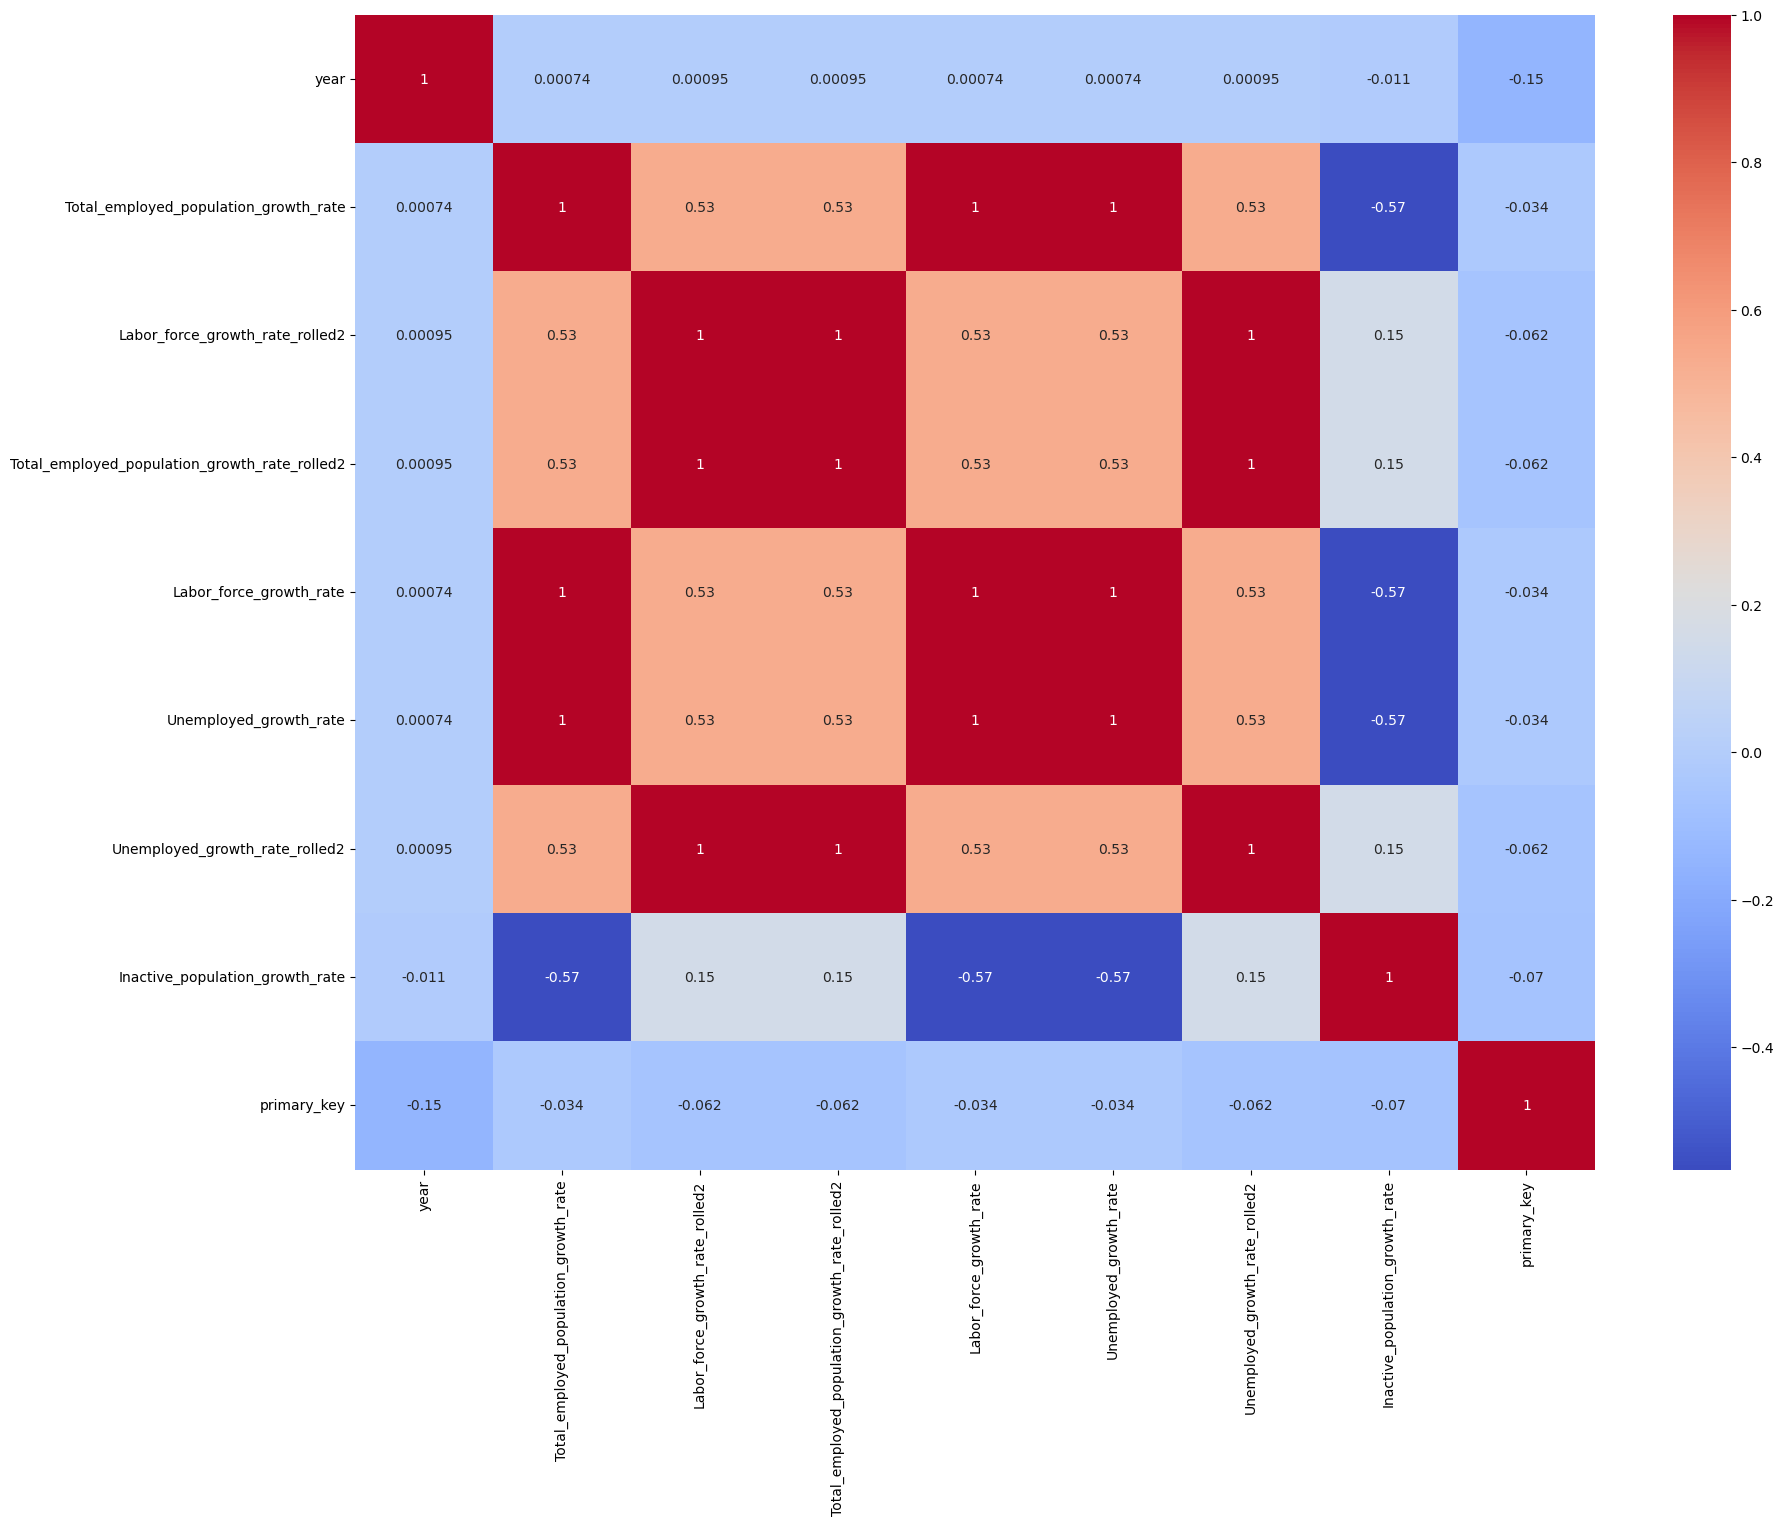

In [87]:
#Heatmap

useful_features_cat_list = useful_features_cat.Feature.values.tolist()
print(useful_features_cat_list)

num_useful_cat_list = ['year', 'Total_employed_population_growth_rate', 'Labor_force_growth_rate_rolled2',
                       'Total_employed_population_growth_rate_rolled2', 'Labor_force_growth_rate', 'Unemployed_growth_rate',
                       'Unemployed_growth_rate_rolled2', 'Inactive_population_growth_rate','primary_key']

plt.figure(figsize=(20,15))
sns.heatmap(data_model[num_useful_cat_list].corr(), annot=True, cmap='coolwarm')

In [88]:
correlation_matrix = data_model[num_useful_cat_list].corr()
correlation_matrix

,year,Total_employed_population_growth_rate,Labor_force_growth_rate_rolled2,Total_employed_population_growth_rate_rolled2,Labor_force_growth_rate,Unemployed_growth_rate,Unemployed_growth_rate_rolled2,Inactive_population_growth_rate,primary_key
year,1.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,-0.15
Total_employed_population_growth_rate,0.00,1.00,0.53,0.53,1.00,1.00,0.53,-0.57,-0.03
Labor_force_growth_rate_rolled2,0.00,0.53,1.00,1.00,0.53,0.53,1.00,0.15,-0.06
Total_employed_population_growth_rate_rolled2,0.00,0.53,1.00,1.00,0.53,0.53,1.00,0.15,-0.06
Labor_force_growth_rate,0.00,1.00,0.53,0.53,1.00,1.00,0.53,-0.57,-0.03
Unemployed_growth_rate,0.00,1.00,0.53,0.53,1.00,1.00,0.53,-0.57,-0.03
Unemployed_growth_rate_rolled2,0.00,0.53,1.00,1.00,0.53,0.53,1.00,0.15,-0.06
Inactive_population_growth_rate,-0.01,-0.57,0.15,0.15,-0.57,-0.57,0.15,1.00,-0.07
primary_key,-0.15,-0.03,-0.06,-0.06,-0.03,-0.03,-0.06,-0.07,1.00


In [89]:
corr_matrix =correlation_matrix.abs()
#Get the upper triangle
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,year,Total_employed_population_growth_rate,Labor_force_growth_rate_rolled2,Total_employed_population_growth_rate_rolled2,Labor_force_growth_rate,Unemployed_growth_rate,Unemployed_growth_rate_rolled2,Inactive_population_growth_rate,primary_key
year,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.15
Total_employed_population_growth_rate,NaN,NaN,0.53,0.53,1.00,1.00,0.53,0.57,0.03
Labor_force_growth_rate_rolled2,NaN,NaN,NaN,1.00,0.53,0.53,1.00,0.15,0.06
Total_employed_population_growth_rate_rolled2,NaN,NaN,NaN,NaN,0.53,0.53,1.00,0.15,0.06
Labor_force_growth_rate,NaN,NaN,NaN,NaN,NaN,1.00,0.53,0.57,0.03
Unemployed_growth_rate,NaN,NaN,NaN,NaN,NaN,NaN,0.53,0.57,0.03
Unemployed_growth_rate_rolled2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,0.06
Inactive_population_growth_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07
primary_key,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
#Columns with corr above 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['Total_employed_population_growth_rate_rolled2',
 'Labor_force_growth_rate',
 'Unemployed_growth_rate',
 'Unemployed_growth_rate_rolled2']

Useful features from CatBoost fixed for Multicollinearity

In [91]:
#useful_features_cat.query(useful_features_cat['Feature'] == 'Labor_force' & useful_features_cat['Feature'] == 'population')
selected_features= useful_features_cat.query("Feature != 'Total_employed_population_growth_rate_rolled2' & Feature != 'Labor_force_growth_rate'& Feature != 'Unemployed_growth_rate'& Feature != 'Unemployed_growth_rate_rolled2'")
selected_features

,Feature,Importance
6,year,72.19
14,Total_employed_population_growth_rate,6.94
17,Labor_force_growth_rate_rolled2,6.36
11,Inactive_population_growth_rate,0.97
7,primary_key,0.83
16,Inactive_population_growth_rate_rolled2,0.28


In [92]:
top_features = selected_features.Feature.values.tolist()
top_features

['year',
 'Total_employed_population_growth_rate',
 'Labor_force_growth_rate_rolled2',
 'Inactive_population_growth_rate',
 'primary_key',
 'Inactive_population_growth_rate_rolled2']

#### 5. Modelling using Best Features from Feature Selection

2022 Predictions

In [93]:
top_features_cat = X_train[top_features].select_dtypes(include='object').columns.tolist()
top_features_cat 

[]

In [94]:
#Create an Instance of the Model
model = CatBoostRegressor(random_state=43, thread_count=-1) #CatBoostRegressor for training and applying regression model

#Fit the model
model.fit(X_train[top_features], Y_train,
         verbose=200, eval_set=(X_test[top_features], Y_test),cat_features =top_features_cat) #Fit method first the CatBoost model

#Make the predictions

train_prediction = model.predict(X_train[top_features]) #Predict method applies the CatBoost model to the dataset
test_prediction = model.predict(X_test[top_features])

Learning rate set to 0.075036
0:	learn: 15853.5196607	test: 62939.1081874	best: 62939.1081874 (0)	total: 2.87ms	remaining: 2.86s
200:	learn: 182.4590169	test: 18816.2214087	best: 18816.2214087 (200)	total: 486ms	remaining: 1.93s
400:	learn: 80.1808386	test: 18592.1600212	best: 18591.8012225 (398)	total: 1.01s	remaining: 1.51s
600:	learn: 52.6263882	test: 18549.7129565	best: 18548.7387880 (593)	total: 1.48s	remaining: 981ms
800:	learn: 39.6530567	test: 18539.8018859	best: 18538.8507585 (772)	total: 1.93s	remaining: 481ms
999:	learn: 29.7995494	test: 18522.8026722	best: 18521.4297417 (995)	total: 2.39s	remaining: 0us

bestTest = 18521.42974
bestIteration = 995

Shrink model to first 996 iterations.


#### 6. Model Evaluation 

In [95]:
#Evaluate the model on train

print('R^2_score:', r2_score(Y_train, train_prediction))
print('MAE:', mean_absolute_error(Y_train, train_prediction))
print('RMSE:', mean_squared_error(Y_train, train_prediction))

R^2_score: 0.9999969150851611
MAE: 10.54174981544694
RMSE: 896.1994199131918


In [96]:
#Evaluate the model on test
print('R^2_score:', r2_score(Y_test, test_prediction))
print('MAE:', mean_absolute_error(Y_test, test_prediction))
print('RMSE:', mean_squared_error(Y_test, test_prediction))

R^2_score: 0.8930967971783172
MAE: 11578.48683004603
RMSE: 343043445.1284706


Save the Model

In [97]:
filename = 'wdl_hackathon.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)

#### 7. Model explainability

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


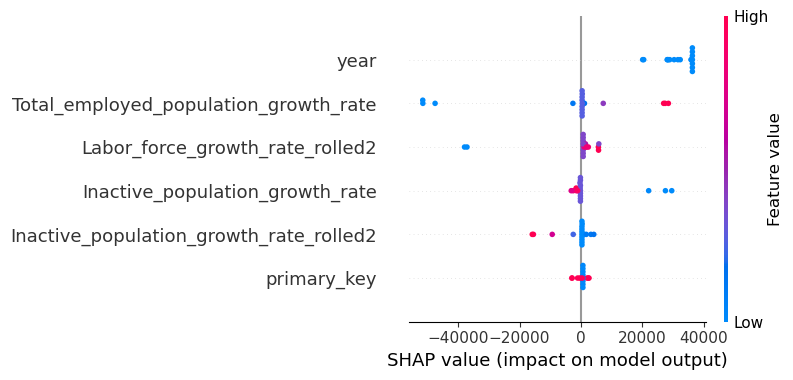

In [98]:
#Using SHAP Explainers

#Initialize SHAP
explainer = shap.TreeExplainer(model)

#Shap values
shap_values = explainer.shap_values(test[top_features])

#PLot SHAP plot
plt.figure(figsize=(50,50))
shap.summary_plot(shap_values, features=test[top_features], feature_names=top_features)

#### 8. Testing Predicted Employed Population in IT Sector for 2023 with Actual 2023 Population

In [99]:
with open('wdl_hackathon.pkl', 'rb') as file:
    final_model = pickle.load(file)

In [100]:
test = pd.read_csv('test_23.csv')
